In [74]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 20
import matplotlib.patches as mpatches

from timeit import default_timer as timer

import my_settings  as st         # configuration file
from helper import *              # load/save   
import util as ut              # utility function
# Simple non zero mean Gaussian Process class adapted for the emulator
from gaussproc_emu import *

# Predict all...

# Start by loading the training results

In [2]:
root_dir = "./"

In [3]:
cosmologies = load_arrays(root_dir + 'trainingset/components', 'cosmologies')
print(f"Cosmo: nber of training Cosmo points {cosmologies.shape[0]} for {cosmologies.shape[1]} params")

Cosmo: nber of training Cosmo points 1000 for 5 params


In [33]:
# Growth factor
growth_factor = load_arrays(root_dir + 'trainingset/components', 'growth_factor')
print(f"Growth Fact: nber of training points {growth_factor.shape[0]} for {growth_factor.shape[1]} z (linear)")
n_gf = growth_factor.shape[1]
assert n_gf == st.nz, "Growth: Hummm something strange..."
print(f"The number of GPs to model Growth={n_gf} (= nber of z_bins) ")
folder_gf = root_dir + '/pknl_components' + st.d_one_plus + '/gf'
arg_gf = [[cosmologies, growth_factor[:, i], st.gf_args, folder_gf, 'gp_' + str(i)] for i in range(n_gf)]


# Pk Linear 
pk_linear = load_arrays(root_dir +'trainingset/components', 'pk_linear')
print(f"Linear Pk: nber of training points {pk_linear.shape[0]} for {pk_linear.shape[1]} k (log)")
n_pl = pk_linear.shape[1]
assert n_pl == st.nk, "Pk lin: Hummm something strange..."
print(f"The number of GPs to model Pklin={n_pl} (= nber of k_bins) ")
folder_pl = root_dir + '/pknl_components' + st.d_one_plus + '/pl'
arg_pl = [[cosmologies, pk_linear[:, i], st.pl_args, folder_pl, 'gp_' + str(i)] for i in range(n_pl)]

# Q-func (= 1+q)
q_function = load_arrays(root_dir +'trainingset/components', 'q_function')
print(f"Q-func: nber of training points {q_function.shape[0]} for {q_function.shape[1]} z x k(lin,log)")
n_qf = q_function.shape[1]
assert n_qf == st.nk * st.nz, "Qfunc: Hummm something strange..."
print(f"The number of GPs to model Q-func={n_qf}")
folder_qf = root_dir + '/pknl_components' + st.d_one_plus + '/qf'
if st.emu_one_plus_q:
    arg_qf = [[cosmologies, 1.0 + q_function[:, i], st.qf_args, folder_qf, 'gp_' + str(i)] for i in range(n_qf)]
else:
    arg_qf = [[cosmologies, q_function[:, i], st.qf_args, folder_qf, 'gp_' + str(i)] for i in range(n_qf)]

Growth Fact: nber of training points 1000 for 20 z (linear)
The number of GPs to model Growth=20 (= nber of z_bins) 
Linear Pk: nber of training points 1000 for 40 k (log)
The number of GPs to model Pklin=40 (= nber of k_bins) 
Q-func: nber of training points 1000 for 800 z x k(lin,log)
The number of GPs to model Q-func=800


# Test with 1 new set of cosmo para.

In [36]:
par = {'omega_cdm': 0.12, 'omega_b': 0.022, 'ln10^{10}A_s': 2.9, 'n_s': 1.0, 'h': 0.75}

theta_star = jnp.array([val for val in par.values()])

#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
theta_star

## Growth factor

In [37]:
#y_trans = False
st.gf_args['y_trans']

False

In [38]:
gf_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.gf_args['y_trans'],
                         use_mean=st.use_mean)

In [39]:
pred_gf = jnp.zeros(n_gf)
for i_gf in range(n_gf):
    gf_model.load_info( arg_gf[i_gf][3], arg_gf[i_gf][4])
    pred_gf_cur = gf_model.simple_predict(theta_star)
    #print(f"[{i_gf}]",gf_model.kernel_hat, gf_model.beta_hat, pred_gf_cur)
    pred_gf= pred_gf.at[i_gf].set(pred_gf_cur)

In [40]:
pred_gf

DeviceArray([0.99999996, 0.79174472, 0.62596249, 0.49891977, 0.4025074 ,
             0.32935536, 0.27328264, 0.22975057, 0.19561521, 0.16824215,
             0.14609959, 0.12797339, 0.11297025, 0.10042569, 0.08983944,
             0.08083005, 0.07310333, 0.06642985, 0.06062888, 0.0555594 ],            dtype=float64)

In [14]:
# training redshifts
zs=jnp.linspace(st.zmin, st.zmax, st.nz, endpoint=True)

z_new = jnp.linspace(st.zmin, st.zmax, 200, endpoint=True)
gf_new = jax.numpy.interp(z_new, zs, pred_gf)

plt.scatter(zs, pred_gf, label=r"$D(\Theta_\ast, z_{train})$")
plt.plot(z_new,gf_new,c="r", label=r"$D(\Theta_\ast,z_\ast)$")
plt.legend()
plt.xlabel("z")
plt.title("Growth Factor")
plt.grid();

# Linear Pk

In [15]:
st.pl_args['y_trans']

True

In [16]:
pl_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.pl_args['y_trans'],
                         use_mean=st.use_mean)

In [17]:
pred_pl = jnp.zeros(n_pl)
for i_pl in range(n_pl):
    pl_model.load_info(arg_pl[i_pl][3], arg_pl[i_pl][4])
    pred_pl_cur = pl_model.pred_original_function(theta_star)
    #print(f"[{i_gf}]",gf_model.kernel_hat, gf_model.beta_hat, pred_gf_cur)
    pred_pl= pred_pl.at[i_pl].set(pred_pl_cur)

In [18]:
# training k
ks = np.geomspace(st.k_min_h_by_Mpc, st.kmax, st.nk, endpoint=True)

In [19]:
k_new = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, 200, endpoint=True)
pl_new = jax.numpy.interp(k_new, ks, pred_pl)

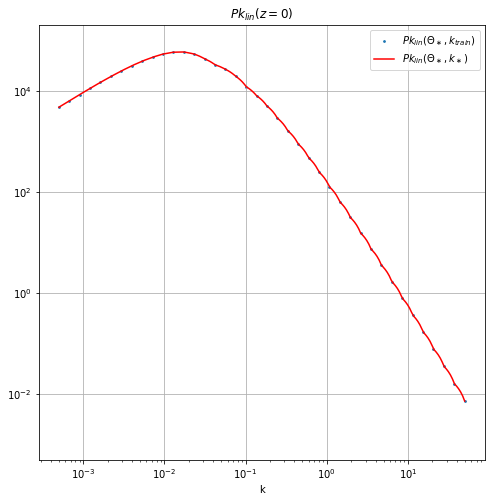

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(ks, pred_pl, s=3,label=r"$Pk_{lin}(\Theta_\ast, k_{train})$")
plt.plot(k_new,pl_new,c="r", label=r"$Pk_{lin}(\Theta_\ast,k_\ast)$")
plt.legend()
plt.xlabel("k")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$Pk_{lin} (z=0)$")
plt.ylim([5e-4,2e5])
plt.grid();

# Q-func

In [21]:
st.qf_args['y_trans']

True

In [22]:
qf_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.qf_args['y_trans'],          ######
                         use_mean=st.use_mean)

In [23]:
pred_qf = jnp.zeros(n_qf)
for i_qf in range(n_qf):
    qf_model.load_info(arg_qf[i_qf][3], arg_qf[i_qf][4])
    pred_qf_cur = qf_model.pred_original_function(theta_star)
    pred_qf= pred_qf.at[i_qf].set(pred_qf_cur)

In [24]:
pred_qf = pred_qf.reshape(st.nk, st.nz)

In [25]:
pred_qf.shape

(40, 20)

In [26]:
#interp2d (x,y,xp,yp,zp)
#    Args:
#        x, y: 1D arrays of point at which to interpolate. Any out-of-bounds
#            coordinates will be clamped to lie in-bounds.
#        xp, yp: 1D arrays of points specifying grid points where function values
#            are provided.
#       zp: 2D array of function values. For a function `f(x, y)` this must
#            satisfy `zp[i, j] = f(xp[i], yp[j])`
#    Returns:
#        1D array `z` satisfying `z[i] = f(x[i], y[i])`.

In [27]:
# qf_new[i] = qf_interp[k_new[i],z_new[i]]; len(k_new)=len(z_new) 
qf_new=ut.interp2d(k_new,z_new,ks,zs,pred_qf)   

# Pk non linear at z=0.5  pour $\Theta_\ast$

In [28]:
z_star = 0.5
D_star = jax.numpy.interp(z_star, zs, pred_gf)

In [29]:
D_star

DeviceArray(0.62105526, dtype=float64)

In [30]:
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, 10000, endpoint=True)
pl_star_z0 = jax.numpy.interp(k_star, ks, pred_pl)
z_star = jnp.array([z_star]*k_star.shape[0])
qf_star = ut.interp2d(k_star,z_star,ks,zs,pred_qf)   

In [31]:
pl_star = D_star * pl_star_z0
pnl_star = pl_star * qf_star 

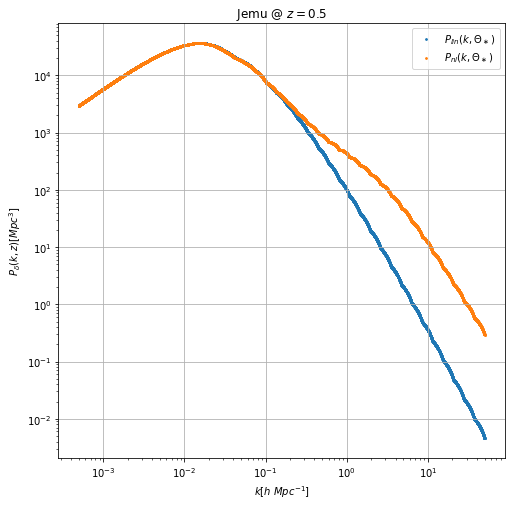

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(k_star,pl_star, s=3, label=r"$P_{lin}(k, \Theta_\ast)$")
plt.scatter(k_star,pnl_star, s=3,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(r"Jemu @ $z=0.5$");

In [61]:
class emuPk():
    def __init__(self,):
        print("New Pk Emulator")
        
        self.z_train = jnp.linspace(st.zmin, st.zmax, st.nz, endpoint=True)
        self.k_train = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, st.nk, endpoint=True)

    def load_all_gps(self, directory: str):
        """
        Load optimizer GPs
        gf: growth factor D(z)
        pl: linear power spectrum P(k,z=0)
        qf: q-function (1+q(k,z))
        """
        
        # Growth factor
        folder_gf = directory + '/gf'
        n_gf = st.nz
        arg_gf = [[folder_gf, 'gp_' + str(i)] for i in range(n_gf)]
        
        self.gps_gf = []
        for i_gf in range(n_gf):
            gf_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.gf_args['y_trans'],
                         use_mean=st.use_mean)
            gf_model.load_info(arg_gf[i_gf][0], arg_gf[i_gf][1])
            self.gps_gf.append(gf_model)
            
        # Linear Pk
        folder_pl = directory + '/pl'
        n_pl = st.nk
        arg_pl = [[folder_pl, 'gp_' + str(i)] for i in range(n_pl)]
        
        self.gps_pl = []
        for i_pl in range(n_pl):
            pl_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.pl_args['y_trans'],
                         use_mean=st.use_mean)
            pl_model.load_info(arg_pl[i_pl][0], arg_pl[i_pl][1])
            self.gps_pl.append(pl_model)
        
        #Q-func
        folder_qf = directory + '/qf'
        n_qf = st.nz * st.nk
        arg_qf = [[folder_qf, 'gp_' + str(i)] for i in range(n_qf)]
        
        self.gps_qf= []
        for i_qf in range(n_qf):
            qf_model = GPEmu(kernel=kernel_RBF,
                         order=st.order,
                         x_trans=st.x_trans,
                         y_trans=st.qf_args['y_trans'],          ######
                         use_mean=st.use_mean)
            qf_model.load_info(arg_qf[i_qf][0], arg_qf[i_qf][1])
            self.gps_qf.append(qf_model)
            
    def gp_kzgrid_pred(self,theta_star):
        """
        Predict GPs at the (k_i,z_j) 'i,j' in st.nk x st.nz grid
        k_i = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, st.nk, endpoint=True)
        z_j = jnp.linspace(st.zmin, st.zmax, st.nz, endpoint=True)
        
        input: theta_star (1D array)
            eg. array([0.12,0.022, 2.9, 1.0, 0.75])
            for {'omega_cdm': 0.12, 'omega_b': 0.022, 'ln10^{10}A_s': 2.9, 'n_s': 1.0, 'h': 0.75}
            
        return: growth factor, non linear pk, linear pk (without growth included)
        """
                
        # Growth @ z_j
        pred_gf = jnp.stack([gf_model.simple_predict(theta_star) for gf_model in self.gps_gf])
        # Linear Pk @ k_i, z=0
        pred_pl_z0 = jnp.stack([pl_model.pred_original_function(theta_star) for pl_model in self.gps_pl])
        
        #Linear Pk @ (k_i,z_j)
        pred_pl = jnp.dot(pred_pl_z0.reshape(st.nk,1), pred_gf.reshape(1,st.nz))
        
        # Q-func @ (k_i, z_j)
        pred_qf = jnp.stack([qf_model.pred_original_function(theta_star) for qf_model in self.gps_qf])

        #Non linear Pk @ (k_i,z_j)
        pred_pnl = pred_qf.reshape(st.nk, st.nz) * pred_pl
        
        
        return pred_pnl, pred_gf, pred_pl_z0
        
    def interp_pk(self,theta_star, k_star, z_star):
        
        """
        interpolation non linear power spectrum aka pk_nl (growth:gf & linear power spec.: pk_l)
 
        input:
         theta_star (1D array)
            eg. array([0.12,0.022, 2.9, 1.0, 0.75])
            for {'omega_cdm': 0.12, 'omega_b': 0.022, 'ln10^{10}A_s': 2.9, 'n_s': 1.0, 'h': 0.75}
         k_star (1D array)
            eg. k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, N, endpoint=True)
         z_star float
            
        return 
           array: pk_nl(theta_star, k_star[i], z_star[i])  i<N
           idem   gf and pk_l
        """
        pred_pnl, pred_gf, pred_pl_z0 = self.gp_kzgrid_pred(theta_star)

        interp_gf    = jax.numpy.interp(z_star, self.z_train, pred_gf)
        interp_pl_z0 = jax.numpy.interp(k_star, self.k_train, pred_pl_z0)
        z_star = jnp.array([z_star]*k_star.shape[0])
        interp_pnl   = ut.interp2d(k_star,z_star,self.k_train,self.z_train,pred_pnl)
        
        return interp_pnl, interp_gf, interp_pl_z0

In [62]:
emu = emuPk()

New Pk Emulator


In [63]:
emu.load_all_gps(directory = root_dir + '/pknl_components' + st.d_one_plus)

In [55]:
par = {'omega_cdm': 0.12, 'omega_b': 0.022, 'ln10^{10}A_s': 2.9, 'n_s': 1.0, 'h': 0.75}
theta_star = jnp.array([val for val in par.values()])
#Omega_cdm h^2, Omega_b h^2, ln(10^10 As), ns, h
theta_star

DeviceArray([0.12 , 0.022, 2.9  , 1.   , 0.75 ], dtype=float64)

In [64]:
pred_gf, pred_pl, pred_qf = emu.gp_kzgrid_pred(theta_star)

In [58]:
pred_gf.shape,pred_pl.shape,pred_qf.shape

((20,), (40,), (800,))

In [67]:
N=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, N, endpoint=True)
z_star = 0.5
pk_nl, gf, pk_lz0 = emu.interp_pk(theta_star, k_star,z_star)

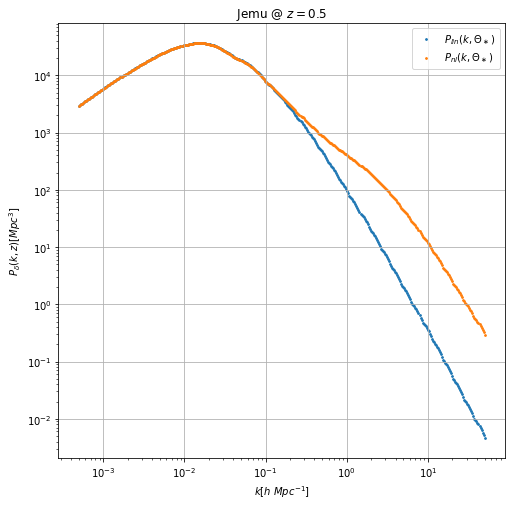

In [71]:
plt.figure(figsize=(8,8))
plt.scatter(k_star,pk_lz0*gf, s=3, label=r"$P_{lin}(k, \Theta_\ast)$")
plt.scatter(k_star,pk_nl, s=3,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"Jemu @ $z={z_star}$");

In [72]:
N=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, st.kmax, N, endpoint=True)
z_star = 1.5
pk_nl, gf, pk_lz0 = emu.interp_pk(theta_star, k_star,z_star)

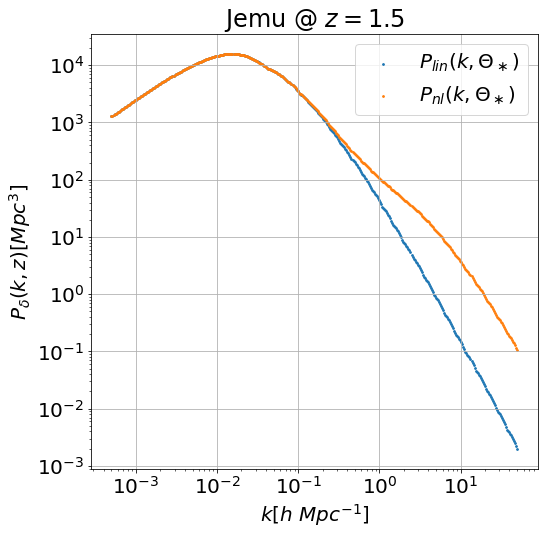

In [75]:
plt.figure(figsize=(8,8))
plt.scatter(k_star,pk_lz0*gf, s=3, label=r"$P_{lin}(k, \Theta_\ast)$")
plt.scatter(k_star,pk_nl, s=3,label=r"$P_{nl}(k, \Theta_\ast)$")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z) [Mpc^3]$")
plt.grid()
plt.title(rf"Jemu @ $z={z_star}$");